In [75]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df_train = pd.read_csv('train.csv')
df_resources = pd.read_csv('resources.csv')
train_resource = pd.merge(df_train, df_resources, on="id", how='left')
df_train[df_train.teacher_prefix.isnull()]
train_resource[train_resource.description.isnull()].head()
t2 = train_resource.pivot_table(index = ['id', 'description'],
                                values='quantity', 
                                aggfunc=np.sum)
t2.reset_index(inplace=True)
train_resource = pd.merge(train_resource,
                          t2, 
                          on=['id', 'description'], 
                          how='right',
                          suffixes=('_Orig', '_True'))

train_resource = train_resource.drop_duplicates()
train_resource = train_resource.drop('quantity_Orig', axis=1)
train_resource = train_resource.rename(columns={'quantity_True': 'True_Quantity'})
train_resource['Total_Cost'] = train_resource.price * train_resource.True_Quantity
Total_cost = train_resource.pivot_table(values=['Total_Cost','True_Quantity'],
                                        index='id',
                                        aggfunc={'Total_Cost' : np.sum, 'True_Quantity' : np.sum})
Total_cost.reset_index(level=0, inplace = True)

df_train = df_train.merge(Total_cost, on='id', how='left')
df_train['Average_item_cost'] = df_train.Total_Cost  / df_train.True_Quantity

df = df_train
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182080 entries, 0 to 182079
Data columns (total 19 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

In [67]:
#https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
from __future__ import print_function

# Remove attributes that arent useful
if 'project_essay_3' in df:
    del df['project_essay_3']
if 'project_essay_4' in df:    
    del df['project_essay_4']

# drop rows that still had missing values after grouped imputation
df.dropna(inplace=True)

# take natural log of right skewed attributes
df['teacher_number_of_previously_posted_projects']=np.log1p(df.teacher_number_of_previously_posted_projects)
df['Total_Cost']=np.log1p(df.Total_Cost)
df['True_Quantity']=np.log1p(df.True_Quantity)
df['Average_item_cost']=np.log1p(df.Average_item_cost)

# perform one-hot encoding of the categorical data
tmp_df = pd.get_dummies(df.teacher_prefix,prefix='teacher_prefix')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.project_grade_category,prefix='project_grade_category')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Keep these attributes
df = df[['teacher_number_of_previously_posted_projects','Total_Cost','True_Quantity','Average_item_cost','project_is_approved'
        ,'teacher_prefix_Teacher','project_grade_category_Grades PreK-2']]
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182073 entries, 0 to 182079
Data columns (total 7 columns):
teacher_number_of_previously_posted_projects    182073 non-null float64
Total_Cost                                      182073 non-null float64
True_Quantity                                   182073 non-null float64
Average_item_cost                               182073 non-null float64
project_is_approved                             182073 non-null int64
teacher_prefix_Teacher                          182073 non-null uint8
project_grade_category_Grades PreK-2            182073 non-null uint8
dtypes: float64(4), int64(1), uint8(2)
memory usage: 8.7 MB


In [68]:
#https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedHighSchoolCampuses.ipynb
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

# we want to predict the X and y data as follows:
if 'project_is_approved' in df:
    y = df['project_is_approved'].values # get the labels we want
    del df['project_is_approved'] # get rid of the class label
    X = df.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced'] #,'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)


Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.4s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:  1.0min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [69]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [70]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X, y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(y,predictions)
    confMat = confusion_matrix(y,predictions)
    acc = accuracy_score(y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X, y, cv)

The average accuracy for all cv folds is: 			 0.56302
The average precision for all cv folds is: 			 0.88607
The average recall for all cv folds is: 			 0.55677
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.561457,0.884988,0.555843
1,0.566674,0.890759,0.558057
2,0.554701,0.879780,0.549163
3,0.566894,0.888684,0.560703
4,0.559095,0.885276,0.552683
5,0.562610,0.881780,0.558043
6,0.561292,0.885533,0.553444
7,0.566674,0.889630,0.560018
8,0.571727,0.888248,0.567264
9,0.559095,0.886058,0.552513


In [71]:
EvaluateClassifierEstimator2(classifierEst, X, y, 10)

             precision    recall  f1-score   support

          0       0.20      0.60      0.30     27734
          1       0.89      0.56      0.68    154339

avg / total       0.78      0.56      0.63    182073

[[16681 11053]
 [68280 86059]]
0.564279162753


In [72]:
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)
====Iteration 0  ====
accuracy 0.56460249897
confusion matrix
 [[ 3275  2270]
 [13585 17285]]
====Iteration 1  ====
accuracy 0.563970891116
confusion matrix
 [[ 3340  2127]
 [13751 17197]]
====Iteration 2  ====
accuracy 0.5659206371
confusion matrix
 [[ 3317  2238]
 [13569 17291]]


In [73]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)  
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.566469861321
[[ 3317  2238]
 [13549 17311]]
Total_Cost has weight of -0.259350096318
project_grade_category_Grades PreK-2 has weight of -0.0404488016446
teacher_prefix_Teacher has weight of -0.0344538496091
True_Quantity has weight of 0.0420629965275
teacher_number_of_previously_posted_projects has weight of 0.229986479984
Average_item_cost has weight of 0.370518539178


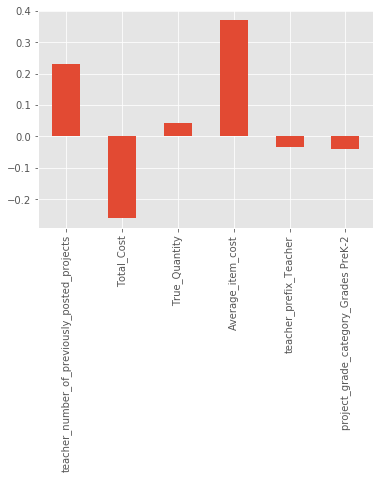

In [74]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(lr_clf.coef_[0],index=df.columns)
weights.plot(kind='bar')
plt.show()